# Fitting the SNR: polynomial regression

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme() # dark theme for plots

### The dataset

We want to try to fit the following dataframe using standard multiple-regression algorithms in sci-kit.

The dataframe has the following structure: $m_1$ (mass of the BH's primary), $m_2$ (mass of the secondary's), $z$ (redshift) and $\rho_{\rm avg}$ (SNR averaged over choices for all other parameters).

In [3]:
df = pd.read_pickle("./dataset_SNRavg.pkl") 
df.columns = ['m1', 'm2', 'z', 'SNR']
df.head()

,m1,m2,z,SNR
0,100.0,5.0,0.5,165.692191
1,100.0,5.0,3.4,21.499814
2,100.0,5.0,6.3,12.674319
3,100.0,5.0,9.2,9.999308
4,100.0,5.0,12.1,7.615063


Check if there are some null values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994 entries, 0 to 2993
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   m1      2994 non-null   float64
 1   m2      2994 non-null   float64
 2   z       2994 non-null   float64
 3   SNR     2994 non-null   float64
dtypes: float64(4)
memory usage: 93.7 KB


### Some data wrangling

To help the fitting procedure we choose variables that are easier to work with, e.g. are closer to order unity. 

We use the log of the total mass and the symmetric mass ratio.

In [5]:
# First sum up the m1 and m2 columns into a single total mass and the ratio into a mass ratio column
df['Mtot'] = df.loc[:,['m1','m2']].sum(axis=1)
df['massratio'] =  (df['m1']*df['m2'])/(df['Mtot']**2) # mass ratio: df['m1']/df['m2']


# Then take the log10 of the SNR and total mass for easier fits.
df['logSNR'] = np.log10(df['SNR'])
df['logMtot'] = np.log10(df['Mtot'])


# Values SNR=0 give infinities, so we replace them with an extremely low value instead.
#df['logSNR'] = df['logSNR'].replace(-np.inf, -10)

# Then we define the new dataframe to contain only total mass, redshift and log of the SNR.
df=df[['logMtot','massratio','z','logSNR']]

df.head()

/opt/miniconda3/envs/gwbench_new/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,logMtot,massratio,z,logSNR
0,2.021189,0.045351,0.5,2.219302
1,2.021189,0.045351,3.4,1.332435
2,2.021189,0.045351,6.3,1.102925
3,2.021189,0.045351,9.2,0.999970
4,2.021189,0.045351,12.1,0.881674


There are some values that are infinity, presumably because they are high redshift/high total mass sources that sift out of band giving an SNR=0 by default. These creates problems since it may give a subclass of the population that is hard to fit.

We aim at removing these, but we first we check if indeed they are high redshift/high total mass sources

In [6]:
# Isolate a dataframe corresponding to SNR = 0
df_infsubset = df.loc[df['logSNR'] == -np.inf]

logMtot_infsubset = df_infsubset.logMtot
z_infsubset = df_infsubset.z

Text(0.5, 0, 'z')

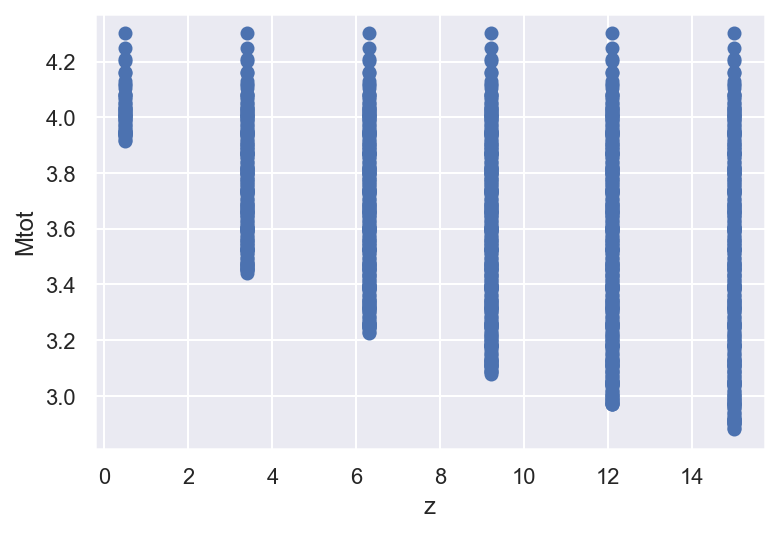

In [7]:
# Plot this in a (Mtot,z) plane

plt.scatter(z_infsubset, logMtot_infsubset)
plt.ylabel('Mtot')
plt.xlabel('z')

Assumption is true. The population of SNR=0 binaries is formed of either high mass sources (which would be out of band), or high redshift sources, which would be too faint to be detected.


In fact, we could remove also the values that have very low SNRs. These are not that interesting for the fit. We just need to make sure we give enough information around the threshold.

In [8]:
# Remove the values with very low SNRs
rho_min = 0.1
df = df[df.logSNR > np.log10(rho_min)]

print('Minimum SNR', min(10**df['logSNR'].values))

Minimum SNR 0.1017133526365298


### Checking correlations and multicollinearity

Check correlations between the data: there appears no strong correlation or multicollinearity. 

<AxesSubplot:>

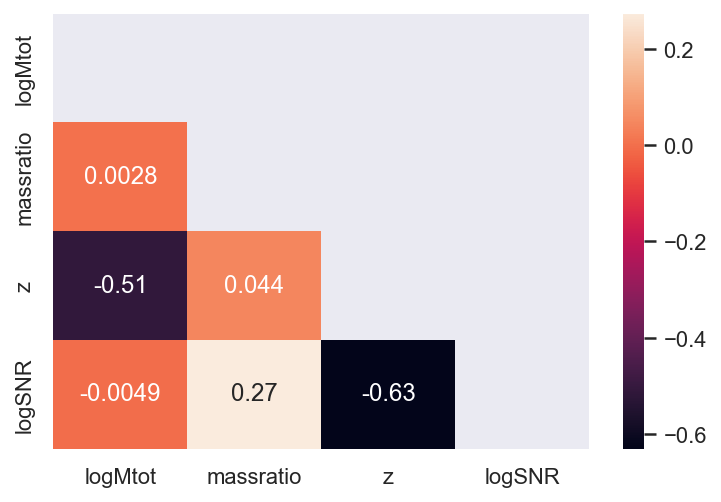

In [9]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(),mask = mask ,annot=True)

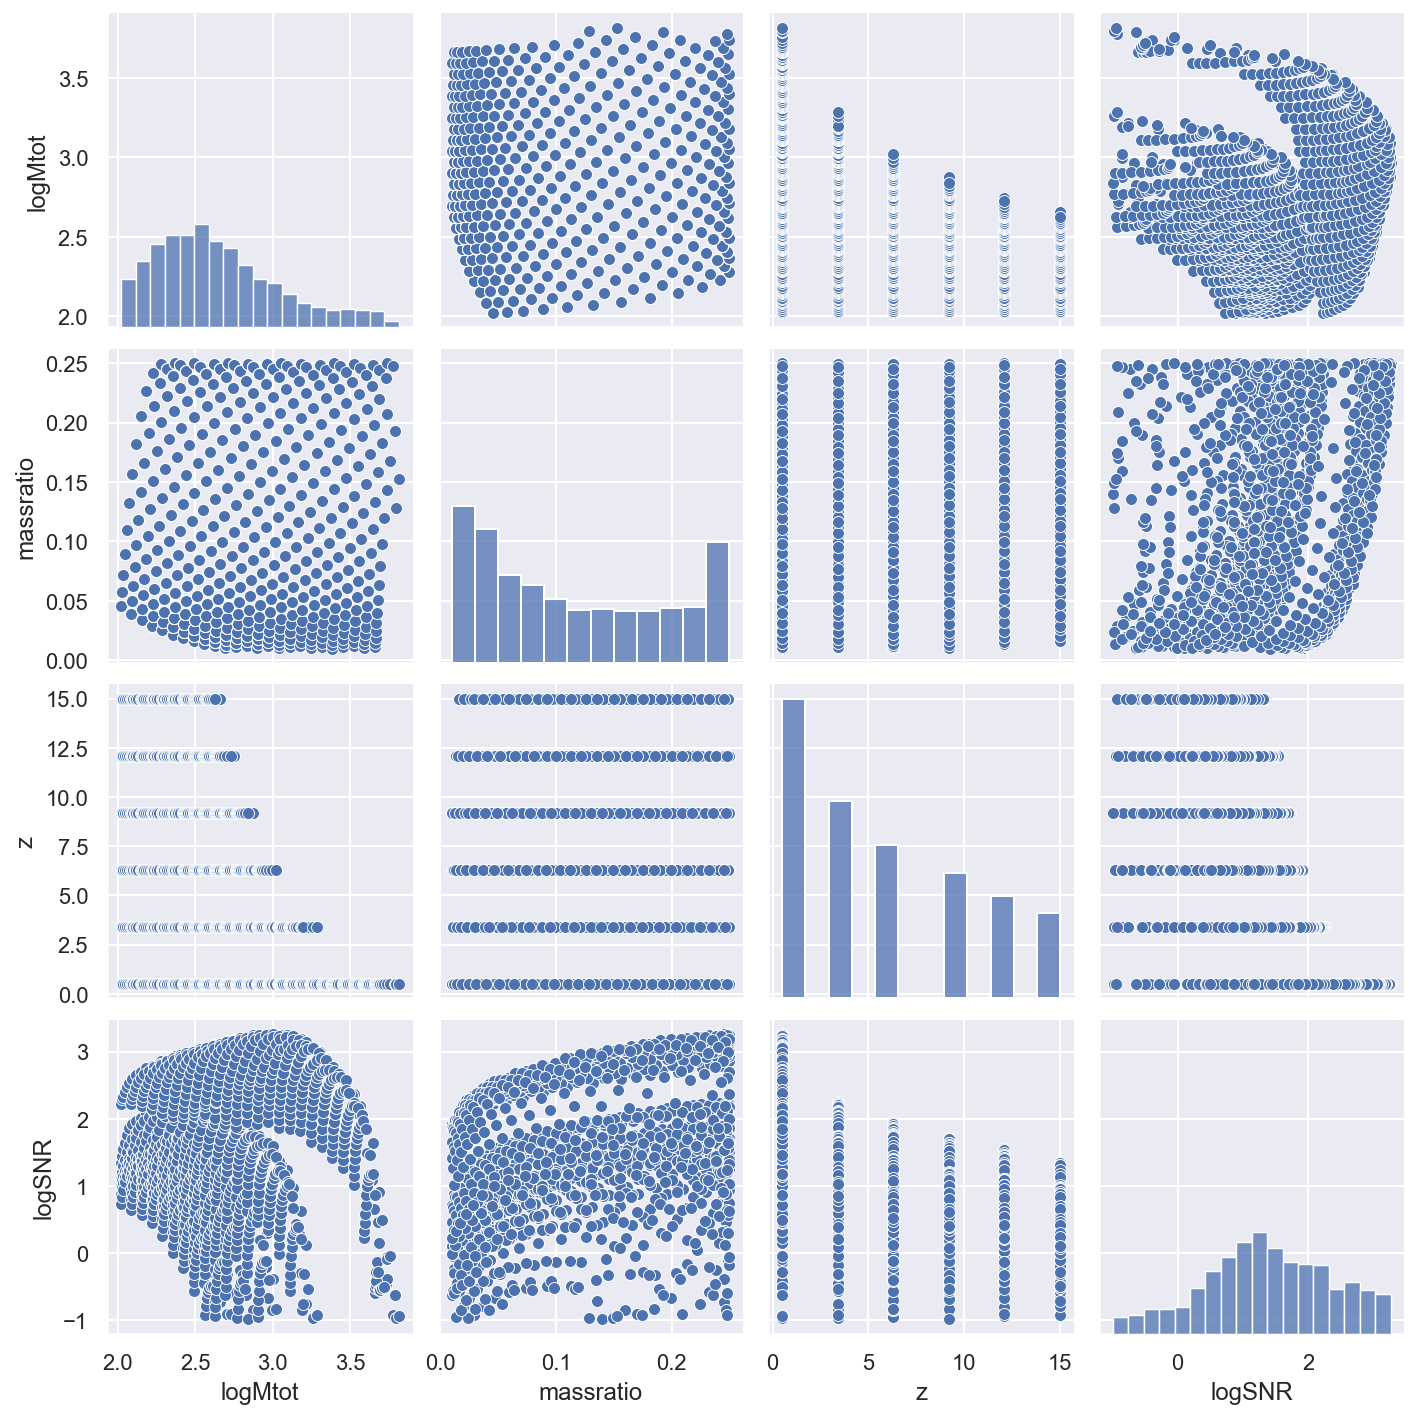

In [10]:
# Get us the pair plots, sns.
fig = sns.pairplot(df)

The interesting patterns appear between the SNR and total mass. That's what we hope to fit. 

## Regression

We begin the fit by splitting the dataframe into training and test set.

In [11]:
# Split into training and data sets using scikit-learn.

from sklearn.model_selection import train_test_split

SNR_mask = df.logSNR > 1e-3 #require a certain SNR threshold in the data frame to avoid numerical issues.
df = df[SNR_mask]


train, test = train_test_split(df, random_state = 2, test_size=0.3)

In [12]:
# Split into (X,y) variables. X = independent variables; y = dependent variable = SNR.

variables = ['logMtot','massratio','z'] 


X_train = train[variables]
X_test = test[variables]

y_train = train.logSNR
y_test = test.logSNR

In [13]:
# Perform the polynomial regression here.

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

# Call the fit.
poly = PolynomialFeatures(degree=5)

# Transform the data so that it can be accepted by a linear model fit.
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

# Fit the model as if it was linear regression.
model = linear_model.LinearRegression()
polyfit = model.fit(X_train_new, y_train)#, sample_weight)

y_pred = polyfit.predict(X_test_new)

### Some metrics

In [14]:
# Get some metrics from statsmodels' ordinary least square regression.

import statsmodels.api as sm


X = sm.add_constant(X_train_new.ravel())
results = sm.OLS(y_train,X_train_new).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logSNR   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3485.
Date:                Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                        07:57:00   Log-Likelihood:                 1274.0
No. Observations:                 831   AIC:                            -2436.
Df Residuals:                     775   BIC:                            -2172.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        426.6699     44.165      9.661      0.000     339.973     513.366
x1          -810.6916     78.757    -10.294      0.000    -965.293    -656.090
x2           384.1422    111.929      3.432      0.001     164.421     603.863
x3           -58.2215      8.742     -6.660      0.000     -75.382     -41.061
x4           610.8084     55.964     10.914      0.000     500.949     720.668
x5          -400.5445    144.688     -2.768      0.006    -684.571    -116.518
x6            93.0983     13.245      7.029      0.000      67.097     119.099
x7         -1873.4750    346.087     -5.413      0.000   -2552.854   -1194.096
x8           -21.8479     14.345     -1.523      0.128     -50.008       6.312
x9             1.1357      0.407      2.789      0.005       0.336       1.935
x10         -227.5983     19.793    -11.499      0.000    -266.452    -188.745
x11          179.4025     72.621      2.470      0.014      36.845     321.960
x12          -56.3166      7.487     -7.522      0.000     -71.014     -41.619
x13          846.3976    284.989      2.970      0.003     286.956    1405.839
x14           24.8162     15.988      1.552      0.121      -6.568      56.200
x15           -1.2499      0.474     -2.636      0.009      -2.181      -0.319
x16         8635.2040    913.078      9.457      0.000    6842.805    1.04e+04
x17           21.4995     24.761      0.868      0.386     -27.106      70.105
x18            0.1560      0.513      0.304      0.761      -0.851       1.163
x19           -0.0183      0.009     -2.037      0.042      -0.036      -0.001
x20           42.0127      3.482     12.066      0.000      35.178      48.848
x21          -38.9981     16.631     -2.345      0.019     -71.645      -6.352
x22           15.1142      1.870      8.081      0.000      11.442      18.786
x23          -82.8670     87.161     -0.951      0.342    -253.966      88.232
x24           -9.6963      6.045     -1.604      0.109     -21.562       2.169
x25            0.5290      0.184      2.873      0.004       0.168       0.890
x26        -3154.3138    424.415     -7.432      0.000   -3987.452   -2321.175
x27            5.3863     16.958      0.318      0.751     -27.902      38.675
x28           -0.3119      0.402     -0.776      0.438      -1.100       0.477
x29            0.0019      0.006      0.290      0.772      -0.011       0.015
x30        -1.618e+04   1770.853     -9.136      0.000   -1.97e+04   -1.27e+04
x31         -148.9968     35.291     -4.222      0.000    -218.273     -79.720
x32            0.4559      0.610      0.748      0.455      -0.741       1.653
x33            0.0100      0.009      1.117      0.265      -0.008       0.028
x34            0.0008      0.000      4.211      0.000       0.000       0.001
x35           -3.0772      0.244    -12.629      0.000      -3.556      -2.599
x3

### Model validation

These codes have been taken from:
https://www.kaggle.com/code/sudhirnl7/linear-regression-tutorial

/opt/miniconda3/envs/gwbench_new/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/miniconda3/envs/gwbench_new/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


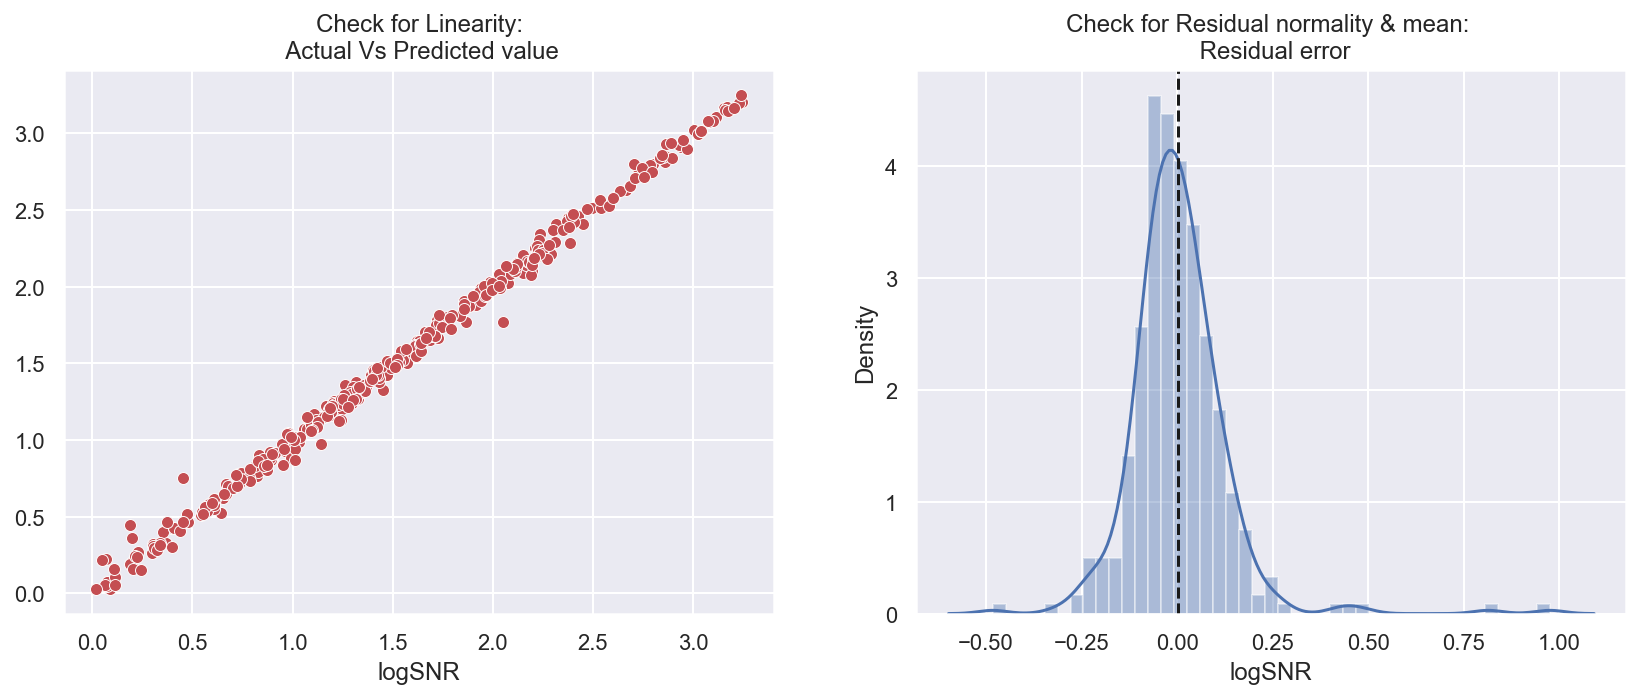

In [15]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)

delta_y  = (10**y_pred- 10**y_test)/ 10**y_test
sns.distplot(delta_y,ax=ax,color='b')
ax.axvline(delta_y.mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual error');

We find that y and predicted y have a linear relations between them, and that the residuals are normally distributed. Both are good signs that the regression algorithms have done their jobs.

We trusted the algorithms, but it's still good to check.

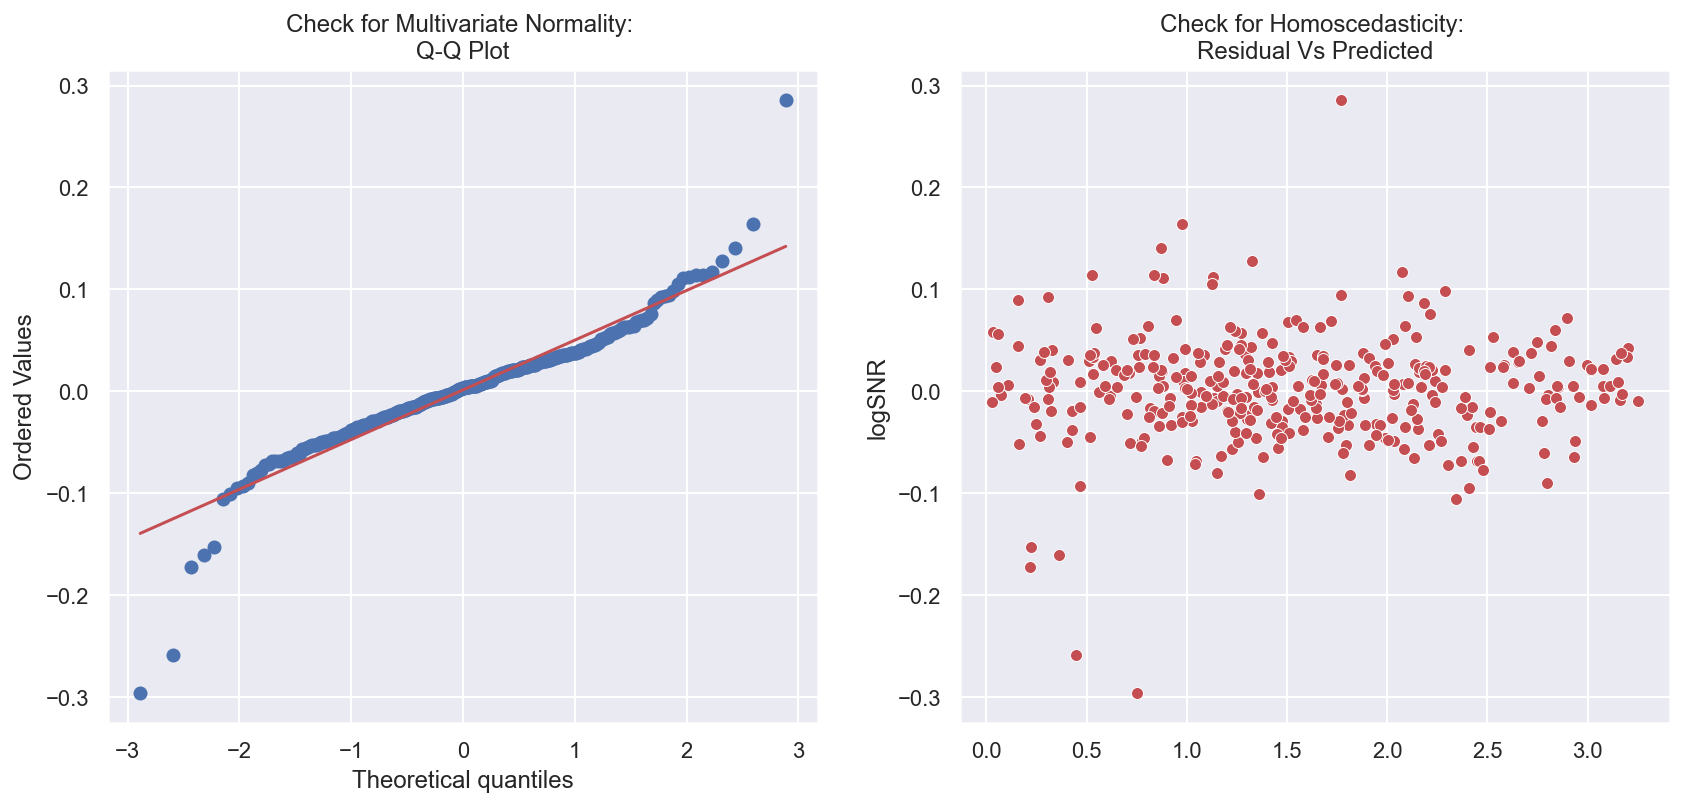

In [16]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred), x= y_pred, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');


### Outlier analysis

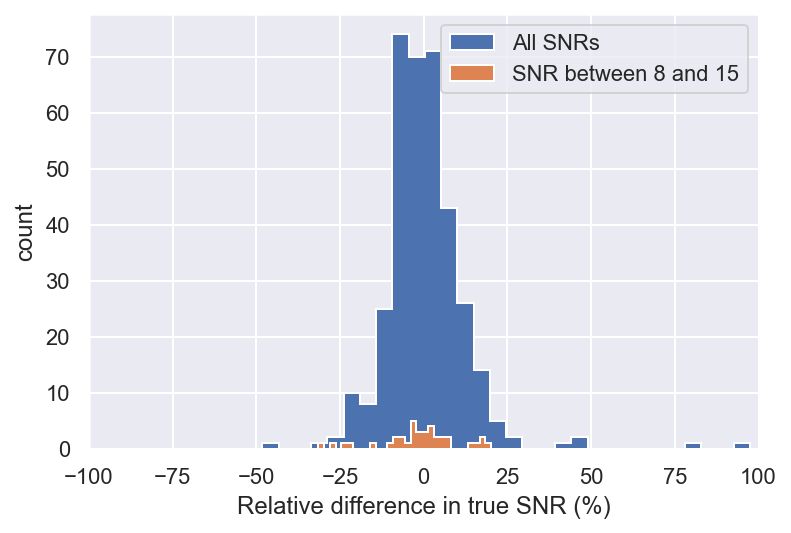

In [17]:
# find error on SNR from the low SNR configurations


mask_lowSNR = np.logical_and(y_test.values > np.log10(8),y_test.values < np.log10(15))
dy_lowSNR =  ((10**y_pred[mask_lowSNR]- 10**y_test[mask_lowSNR])/ 10**y_test[mask_lowSNR]).values
dy = ((10**y_pred- 10**y_test)/ 10**y_test).values 

plt.hist(dy * 100,bins=30, histtype ='stepfilled', label='All SNRs')
plt.hist(dy_lowSNR * 100,bins=30, histtype ='stepfilled',label='SNR between 8 and 15')

plt.ylabel('count')
plt.xlabel(r'Relative difference in true SNR (%)')
plt.xlim(-100,100)
plt.legend(loc='best')

We see that the SNRs between 8 and 15, which is a range where we'd expect detector thresholds to be put, are broader and would predict larger relative differences that the combinations of all SNRs. On average. 

The differences do not exceed 25%, which is within the order(few) changes we'd expect from random realizations of angles and spins as compared to the averaged SNRs used here.

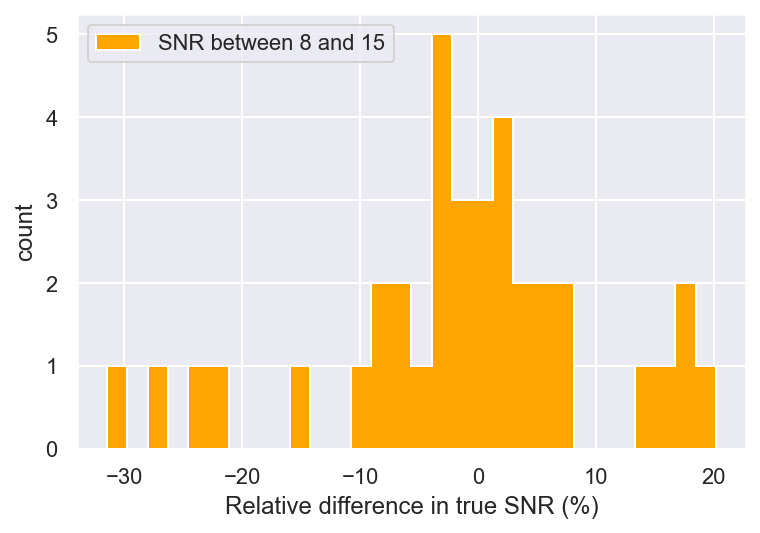

In [18]:
# Isolate the contributions from SNRs 8 to 15.

plt.hist(dy_lowSNR * 100,bins=30, histtype ='stepfilled',label='SNR between 8 and 15',color='orange');
plt.ylabel('count')
plt.xlabel(r'Relative difference in true SNR (%)')
plt.legend(loc='upper left')

In [19]:
# Find some metrics for the maximum outlier.

count = -1

index = np.where(dy == np.sort(dy)[count])[0][0]#np.argmax(np.abs(dy))
print('dy=',np.sort(dy)[count])

ypred_maxoutlier = y_pred[index]
ytest_maxoutlier = y_test.values[index]

print('Max outlier located at', (ypred_maxoutlier - ytest_maxoutlier)/ytest_maxoutlier)
print('SNR predicted',10**ypred_maxoutlier)
print('SNR test',10**ytest_maxoutlier)
print('SNR predicted/ SNR test',10**ypred_maxoutlier/10**ytest_maxoutlier)

dy= 0.9750030591096517
Max outlier located at 0.650420797663675
SNR predicted 5.623325675574865
SNR test 2.847249096469708
SNR predicted/ SNR test 1.9750030591096517


In [20]:
# Where does the point lie?

print('Total mass at outlier:',df['logMtot'].values[index])
print('mass ratio at outlier:',df['massratio'].values[index])
print('Redshift at outlier:',df['z'].values[index])

Total mass at outlier: 2.3425321787946
mass ratio at outlier: 0.12205850870327417
Redshift at outlier: 3.4


### Using the fit

Below is an example of how the fit could be used.

In [21]:
def SNR_fit(Mtot, eta, z):
    
    """
    Function to return the SNR from a given 
    total mass, mass ratio, and redshift.
    """
    
    logMtot = np.log10(Mtot)
    input_ = [[logMtot, eta, z]]
    X_temp = poly.fit_transform(pd.DataFrame(input_))
    
    return 10**polyfit.predict(X_temp)[0]

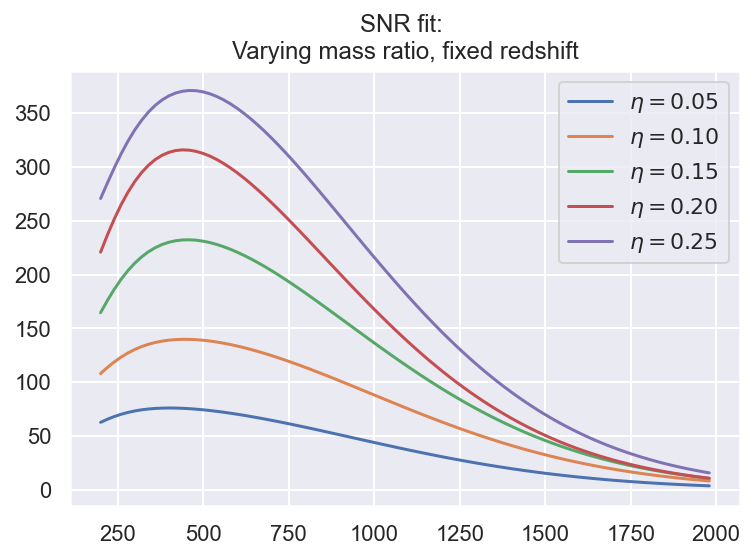

In [22]:
# Plot the predicted SNRs as a function of the total mass at a specified redshift.

redshift = 2

nsteps = 20
Mmin = 200
Mmax = 2000
Mtot_range = [Mtot for Mtot in arange(Mmin,Mmax,nsteps)]

plt.plot(Mtot_range, [SNR_fit(Mtot,0.05,redshift) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$\eta = 0.05$')
plt.plot(Mtot_range, [SNR_fit(Mtot,0.1,redshift) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$\eta = 0.10$')
plt.plot(Mtot_range, [SNR_fit(Mtot,0.15,redshift) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$\eta = 0.15$')
plt.plot(Mtot_range, [SNR_fit(Mtot,0.2,redshift) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$\eta = 0.20$')
plt.plot(Mtot_range, [SNR_fit(Mtot,0.25,redshift) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$\eta = 0.25$')
plt.title('SNR fit: \nVarying mass ratio, fixed redshift');
plt.legend()

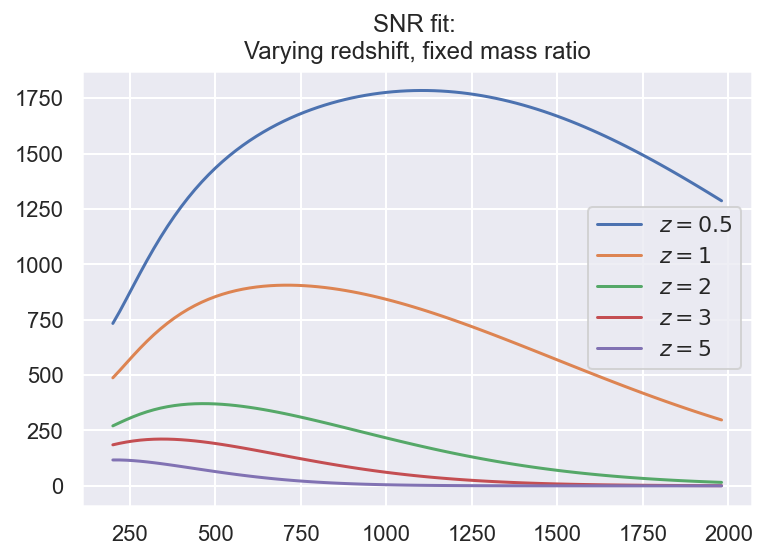

In [23]:
# Same, but with a different mass ratio.

mass_ratio = 0.25

nsteps = 20
Mmin = 200
Mmax = 2000
Mtot_range = [Mtot for Mtot in arange(Mmin,Mmax,nsteps)]

plt.plot(Mtot_range, [SNR_fit(Mtot,mass_ratio,0.5) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$z = 0.5$')
plt.plot(Mtot_range, [SNR_fit(Mtot,mass_ratio,1.0) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$z = 1$')
plt.plot(Mtot_range, [SNR_fit(Mtot,mass_ratio,2.0) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$z = 2$')
plt.plot(Mtot_range, [SNR_fit(Mtot,mass_ratio,3.0) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$z = 3$')
plt.plot(Mtot_range, [SNR_fit(Mtot,mass_ratio,5.0) for Mtot in arange(Mmin,Mmax,nsteps)],label=r'$z = 5$')
plt.title('SNR fit: \nVarying redshift, fixed mass ratio');
plt.legend()

### Checking the results

Finally we check the results against mock SNR calculations from a random population. This has been done offline and saved into a pickle file. 

The file contains random masses and redshift across the same range used for the fit, and the associated SNR that we should be able to broadly predict.

In [24]:
# Here is a validation dataset generated with gwbench.

df_validation = pd.read_pickle("./validation_N20_dataset_SNRavg.pkl") 
# df_validation = pd.read_pickle("./validation_dataset_SNRavg.pkl") 
df_validation.columns = ['m1', 'm2', 'z', 'SNR']
df_validation

,m1,m2,z,SNR
0,108.852523,5.674318,0.778591,112.964014
1,108.852523,5.674318,1.128847,74.264523
2,108.852523,5.674318,2.254678,34.580995
3,108.852523,5.674318,2.398139,32.544843
4,108.852523,5.674318,3.077627,25.749291
...,...,...,...,...
3295,7389.132490,6353.081225,13.311465,0.000000
3296,7389.132490,6353.081225,13.550694,0.000000
3297,7389.132490,6353.081225,13.760608,0.000000
3298,7389.132490,6353.081225,14.109664,0.000000


In [25]:
# transform m1 and m2 to logMtot and mass ratio

df_validation['Mtot'] = df_validation.loc[:,['m1','m2']].sum(axis=1)
df_validation['massratio'] =  (df_validation['m1']*df_validation['m2'])/(df_validation['Mtot']**2)
df_validation['logSNR'] = np.log10(df_validation['SNR'])
df_validation['logMtot'] = np.log10(df_validation['Mtot'])
df_validation=df_validation[['logMtot','massratio','z','logSNR']]

df_validation.head()

/opt/miniconda3/envs/gwbench_new/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,logMtot,massratio,z,logSNR
0,2.058907,0.047091,0.778591,2.052940
1,2.058907,0.047091,1.128847,1.870781
2,2.058907,0.047091,2.254678,1.538837
3,2.058907,0.047091,2.398139,1.512482
4,2.058907,0.047091,3.077627,1.410765


In [26]:
# Isolate the values predicted through our fitting function and the ones obtained offline.

SNR_gwbench = (10**df_validation['logSNR'].values)
SNR_predicted = [SNR_fit(10**(df_validation['logMtot'][i]),
        df_validation['massratio'][i], 
        df_validation['z'][i]) for i in range(0,len(df_validation['logSNR'].values))];

Text(0.5, 0, 'True SNR from gwbench')

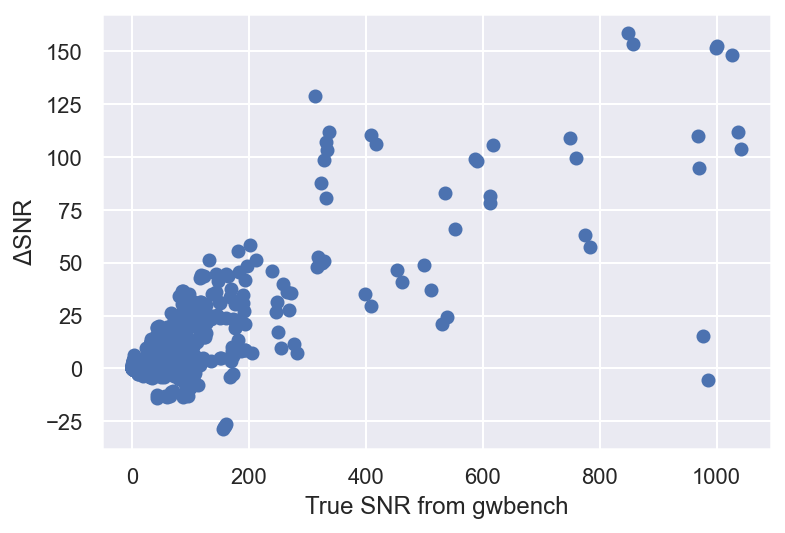

In [27]:
# Scatter of difference from predicted and actual values.

plt.scatter(SNR_gwbench, SNR_predicted - SNR_gwbench)

plt.ylabel(r'$\Delta$SNR')
plt.xlabel('True SNR from gwbench')

/opt/miniconda3/envs/gwbench_new/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'True SNR from gwbench')

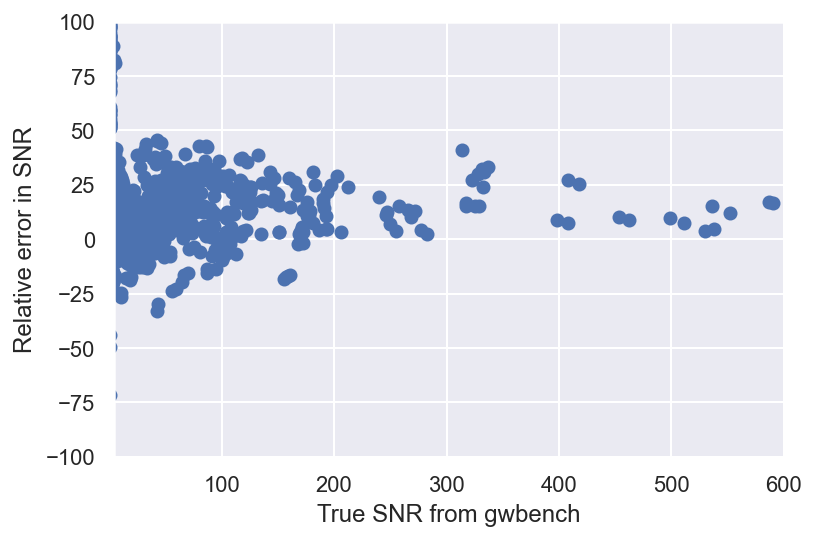

In [28]:
# Histogram of the relative error

SNR_rel_error = (SNR_predicted - SNR_gwbench)/SNR_gwbench * 100
SNR_rel_error[SNR_rel_error == inf] = 0

plt.scatter(SNR_gwbench,SNR_rel_error)
plt.xlim(4,600)
plt.ylim(-100,100)
plt.ylabel('Relative error in SNR')
plt.xlabel('True SNR from gwbench')

This is great! we are broadly within the 25% difference in SNR, which was more or less what we were finding with the test data. 

------

... aaaand here we find that the distribution of SNRs is also predicted well with the fit.

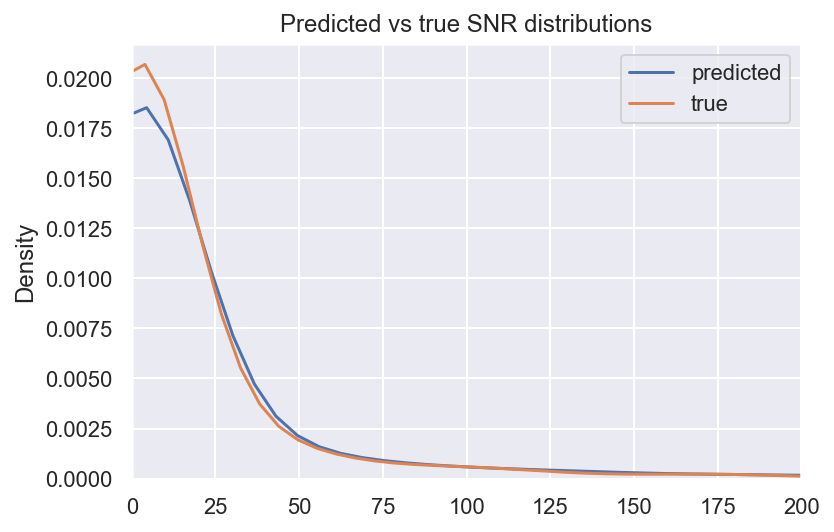

In [29]:
# Check the predicted vs true SNR distributions.

sns.kdeplot(SNR_predicted, label='predicted')
sns.kdeplot(SNR_gwbench, label='true')
plt.xlim(-100,200)
plt.title('Predicted vs true SNR distributions');
plt.xlim(0,200)
plt.legend()

## Predictions vs validation population

*Choose the SNR threshold here*

In [30]:
SNR_threshold = 12

Here's the entire scatter plot with mock and predicted populations

Text(0.5, 0, 'True SNR from gwbench')

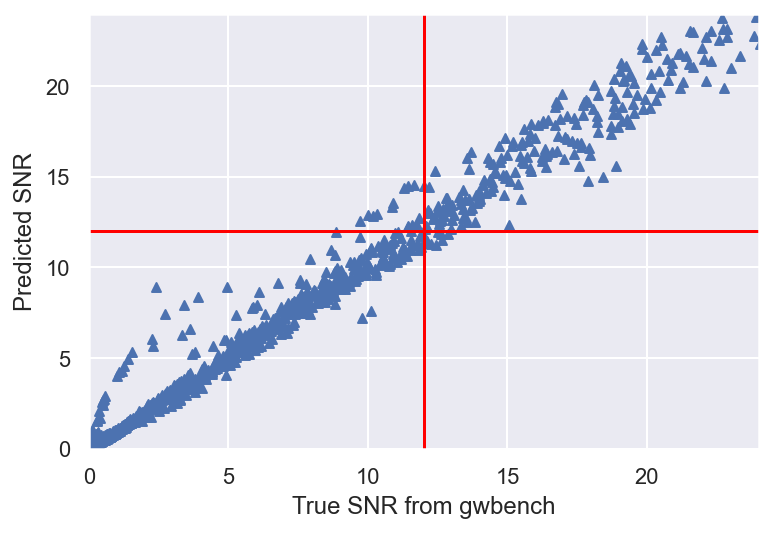

In [31]:
# Money plot

plt.scatter(SNR_gwbench, SNR_predicted, marker='^',s=20)
plt.ylim(0,2*SNR_threshold)
plt.xlim(0,2*SNR_threshold)

plt.axvline(SNR_threshold, color='red')
plt.axhline(SNR_threshold, color='red')


plt.ylabel('Predicted SNR')
plt.xlabel('True SNR from gwbench')

-----

**False negatives** (predicted below the threshold, but should be above)

-----

In [32]:
cond = df_validation['logSNR'] < np.log10(SNR_threshold) # Keep mock SNRs above the threshold.
df_validation_masked = df_validation.mask(cond=cond).dropna()
nsamples = len(df_validation_masked)
print('Total number of SNRs predicted above the SNR threshold:',nsamples)

Total number of SNRs predicted above the SNR threshold: 714


In [33]:
SNR_gwbench_masked_neg = (10**df_validation_masked['logSNR'].values)
SNR_predicted_masked_neg = [SNR_fit(10**(df_validation_masked['logMtot'].values[i]),
        df_validation_masked['massratio'].values[i], 
        df_validation_masked['z'].values[i]) for i in range(0,len(df_validation_masked['logSNR'].values))];

Text(0.5, 0, 'True SNR from gwbench')

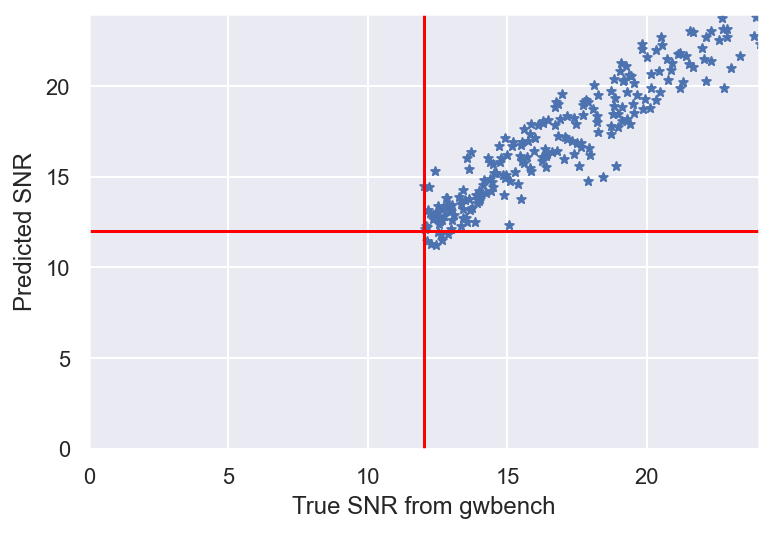

In [34]:
# False negatives plot.

plt.scatter(SNR_gwbench_masked_neg, SNR_predicted_masked_neg,  marker='*',s=20)

plt.ylim(0,2*SNR_threshold)
plt.xlim(0,2*SNR_threshold)
plt.axvline(SNR_threshold, color='red')
plt.axhline(SNR_threshold, color='red')


plt.ylabel('Predicted SNR')
plt.xlabel('True SNR from gwbench')

In [35]:
# True is equal to 1.
n_falseneg = sum([SNR < SNR_threshold for SNR in SNR_predicted_masked_neg])

print('Number of false negatives:', n_falseneg)
print(round(n_falseneg/nsamples * 100,2),' % are predicted below the SNR threshold, but should be above.')

Number of false negatives: 7
0.98  % are predicted below the SNR threshold, but should be above.


In [36]:
SNR_mask_predicted = [SNR < SNR_threshold for SNR in SNR_predicted_masked_neg]
false_negatives = np.array(SNR_predicted_masked_neg)[SNR_mask_predicted]

print('The false negatives are:', false_negatives)

The false negatives are: [11.86388527 11.51387506 11.29248923 11.85544234 11.93751411 11.44623956
 11.23346833]


-----

**False positives** (predicted above the threshold, but should be below)

-----

In [37]:
cond = df_validation['logSNR'] > np.log10(SNR_threshold) # Keep mock SNRs below the threshold.
df_validation_masked = df_validation.mask(cond=cond).dropna()
nsamples = len(df_validation_masked)
print('Total number of SNRs predicted above the SNR threshold:',nsamples)

Total number of SNRs predicted above the SNR threshold: 2586


In [38]:
SNR_gwbench_masked_pos = (10**df_validation_masked['logSNR'].values)
SNR_predicted_masked_pos = [SNR_fit(10**(df_validation_masked['logMtot'].values[i]),
        df_validation_masked['massratio'].values[i], 
        df_validation_masked['z'].values[i]) for i in range(0,len(df_validation_masked['logSNR'].values))];

Text(0.5, 0, 'True SNR from gwbench')

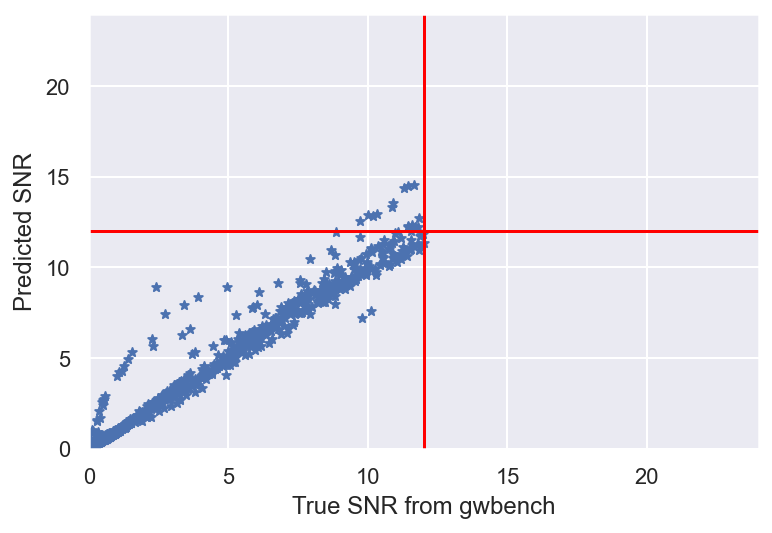

In [39]:
# False positives plot.

plt.scatter(SNR_gwbench_masked_pos, SNR_predicted_masked_pos,  marker='*',s=20)

plt.ylim(0,2*SNR_threshold)
plt.xlim(0,2*SNR_threshold)
plt.axvline(SNR_threshold, color='red')
plt.axhline(SNR_threshold, color='red')


plt.ylabel('Predicted SNR')
plt.xlabel('True SNR from gwbench')

In [40]:
# True is equal to 1.
n_falsepositive = sum([SNR > SNR_threshold for SNR in SNR_predicted_masked_pos])

print('Number of false negatives:', n_falsepositive)
print(round(n_falsepositive/nsamples * 100,2),' % are predicted above the SNR threshold, but should be below.')

Number of false negatives: 15
0.58  % are predicted above the SNR threshold, but should be below.


In [41]:
SNR_mask_predicted = [SNR > SNR_threshold for SNR in SNR_predicted_masked_pos]
false_positives = np.array(SNR_predicted_masked_pos)[SNR_mask_predicted]

print('The false positives are:', false_positives)

The false positives are: [12.31655021 12.22079443 12.72809582 12.29926085 12.23930556 12.23825171
 14.49856434 12.94473634 14.37482835 12.82807979 14.56438117 12.86598448
 13.55225975 12.55485002 13.35540758]


### Final plot

In [42]:
# Nice plotting options.

import matplotlib as mpl

sns.set_theme(style="white")

params = {'axes.labelsize': 35,
          'font.family': 'serif',
        
          'font.serif': 'Computer Modern Raman',
          'font.size': 30,
          'axes.linewidth': 1,
          'legend.fontsize': 30,
          'xtick.labelsize': 33,
          'xtick.top': True,
          'ytick.labelsize': 30,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 24,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

We predict the numbers in the four quadrants now.

In [43]:
array_I = []
array_II = []
array_III = []
array_IV   = []


for a,b in zip(SNR_gwbench,SNR_predicted):
    
    if (a <SNR_threshold) and (b > SNR_threshold):
        array_I.append([a,b]) 
    if (a >SNR_threshold) and (b > SNR_threshold):
        array_II.append([a,b]) 
    if (a <SNR_threshold) and (b < SNR_threshold):
        array_III.append([a,b]) 
    if (a >SNR_threshold) and (b < SNR_threshold):
        array_IV.append([a,b]) 

And finally the money plot

Text(0.5, 0, 'Mock SNR')

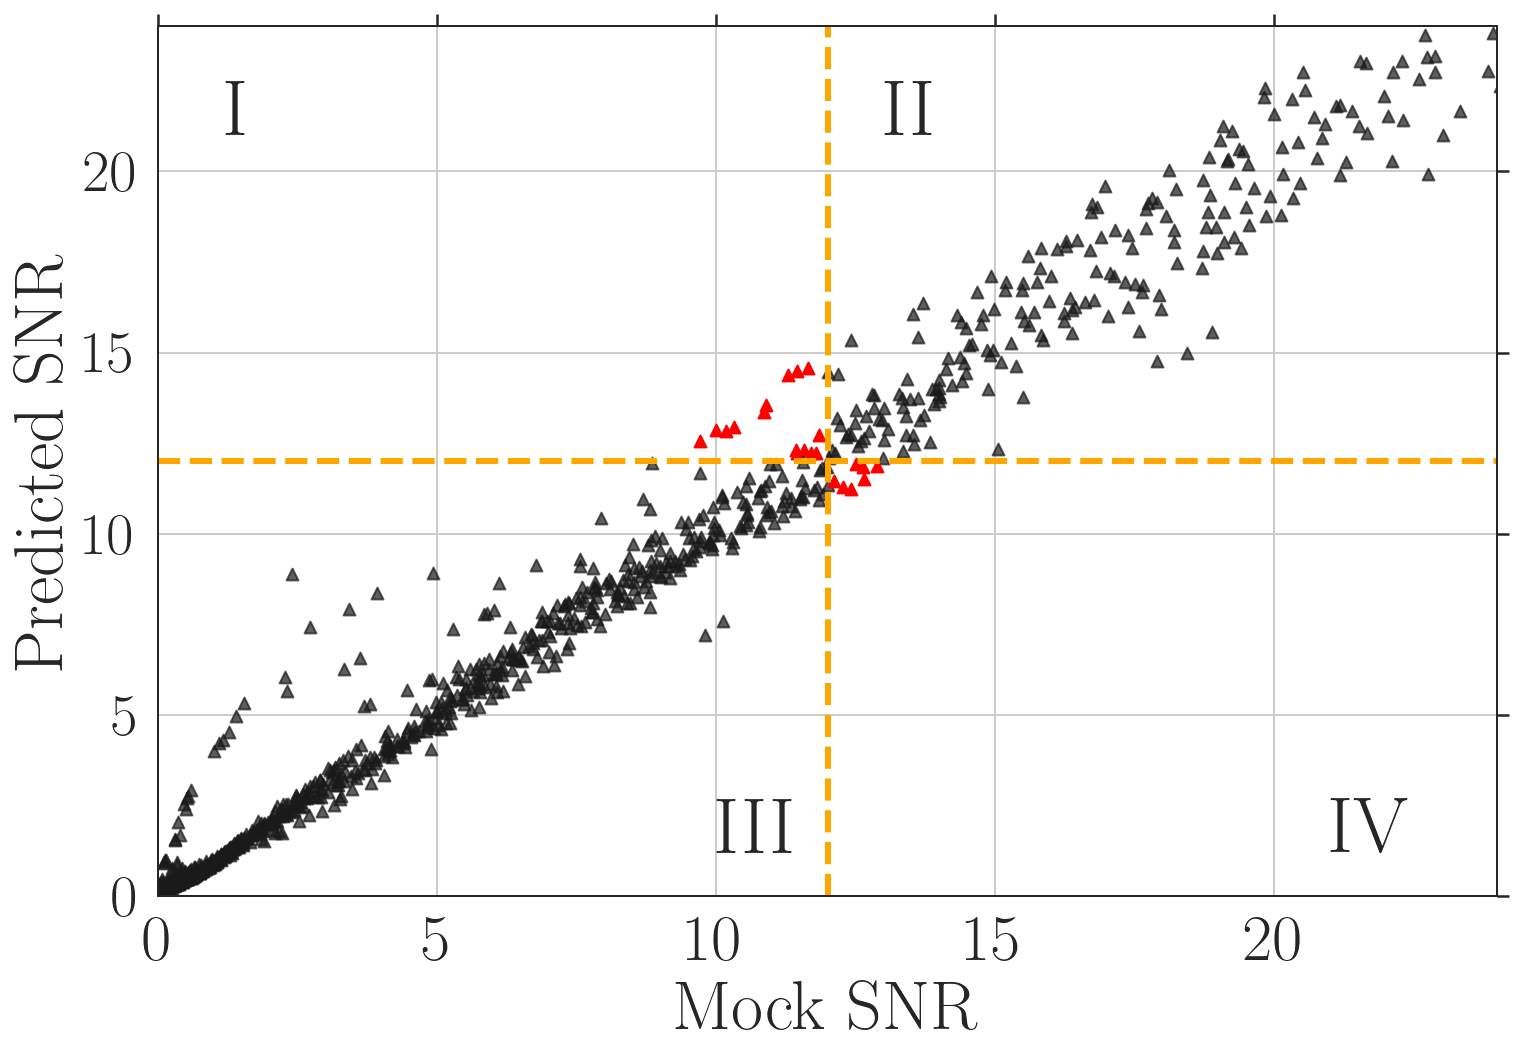

In [44]:
# Money plot

fig, axes = plt.subplots()
fig.set_size_inches(12, 8)

for element in array_I:
    xi,yi = element
    plt.scatter(xi,yi, marker='^',s=35, color='red')
    
for element in array_III:
    xi,yi = element
    plt.scatter(xi,yi, marker='^',s=35, color='k', alpha=0.7)
    
for element in array_II:
    xi,yi = element
    plt.scatter(xi,yi, marker='^',s=35, color='k', alpha=0.7)
    
for element in array_IV:
    xi,yi = element
    plt.scatter(xi,yi, marker='^',s=35, color='red')
    
    
plt.ylim(0,2*SNR_threshold)
plt.xlim(0,2*SNR_threshold)

plt.axvline(SNR_threshold, color='orange', ls='dashed', lw=3)
plt.axhline(SNR_threshold, color='orange', ls='dashed', lw=3)

# Add text

plt.text(1.2, 21, 'I', fontsize = 40)
plt.text(13, 21, 'II', fontsize = 40)
plt.text(10, 1.2, 'III', fontsize = 40)
plt.text(21, 1.2, 'IV', fontsize = 40)

plt.ylabel('Predicted SNR')
plt.xlabel('Mock SNR')

#plt.savefig('SNRfit_validation.pdf')

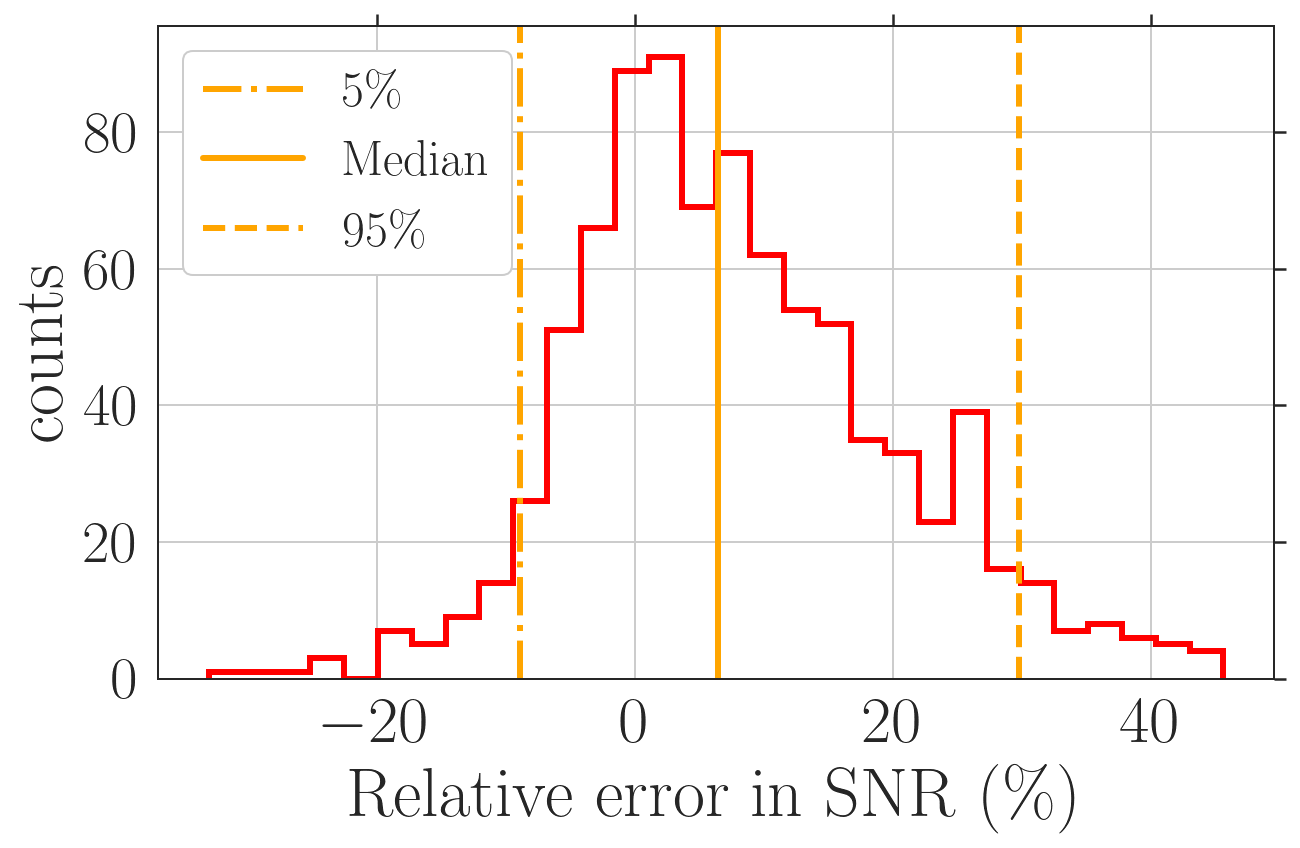

In [45]:
# Histogram of the relative error

fig, axes = plt.subplots()
fig.set_size_inches(10, 6)

SNR_mask = SNR_gwbench>8

SNR_predicted = np.array(SNR_predicted) # Make it an array
SNR_predicted_masked = SNR_predicted[SNR_mask] #And mask it.
SNR_gwbench_masked = SNR_gwbench[SNR_mask]

SNR_rel_error = (SNR_predicted_masked - SNR_gwbench_masked)/SNR_gwbench_masked * 100

plt.hist(SNR_rel_error, bins=30, histtype='step', color='red', lw=3)
plt.xlabel('Relative error in SNR ($\%$)')
plt.ylabel('counts')

plt.axvline(np.percentile(SNR_rel_error, 5) , ls='-.', color='orange', lw=3, label='5$\%$')  # 5 percentile
plt.axvline(np.percentile(SNR_rel_error, 50), ls='-', color='orange', lw=3, label='Median') # 50 percentile
plt.axvline(np.percentile(SNR_rel_error, 95), ls='--', color='orange', lw=3, label='95$\%$') # 95 percentile

plt.legend(loc='upper left', fontsize=25, framealpha=1)
#plt.savefig('relative_error_hist.pdf')